# Pipeline: Regression Models

## 1. Introduction

Ten years' worth of AstraZeneca Adjusted Close price data will be used to see if it possible to forecast out 'n' days in the future. Fourteen models will be compared to see whether Gradient-Descent Based, Distance-Based or Tree-Based algorithms perform best.

After a spot check of the models the best performing will be selected and Grid Search cross validation will then be used to find the best parameters for tuning the models, and visualising the results.




## 2. Install/import libraries

In [ ]:
!pip install yfinance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

%matplotlib inline

# Import the models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')


## 3. Import data
Ten years of AstraZeneca stock data will be downloaded from Yahoo! Finance using the yfinance API.

In [2]:
azn_df = yf.download("AZN.L", start="2013-01-01", end="2023-10-10")[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)

[*********************100%%**********************]  1 of 1 completed


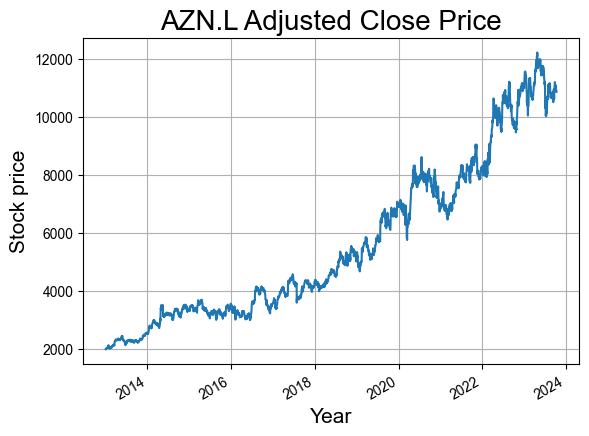

In [3]:
# Plot Adjusted Close price

azn_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(18, 9)})
plt.title('AZN.L Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

In [4]:
# Create Dataframe for Adjusted Close prices

azn_adj = azn_df[['Adj Close']]
azn_adj 

,Adj Close
Date,
2013-01-02,1974.84
2013-01-03,1982.16
2013-01-04,1995.46
2013-01-07,1985.48
2013-01-08,1995.46
...,...
2023-10-03,10908.00
2023-10-04,10892.00
2023-10-05,10902.00


## 4. Feature engineering
The Adjusted Close price will be shifted 'n' days in the future to create a column of prices for prediction.

In [5]:
# A variable for predicting 'n' days into the future

forecast_out = 30

# Create column for target variable shifted 'n' days up
azn_adj['Prediction'] = azn_adj[['Adj Close']].shift(-forecast_out)

azn_adj

,Adj Close,Prediction
Date,,
2013-01-02,1974.84,2043.79
2013-01-03,1982.16,2028.20
2013-01-04,1995.46,2034.09
2013-01-07,1985.48,2017.47
2013-01-08,1995.46,2042.75
...,...,...
2023-10-03,10908.00,NaN
2023-10-04,10892.00,NaN
2023-10-05,10902.00,NaN


## 5. Splitting the data

The last 'n' rows will be removed as these rows are NaNs in the Prediction column (y variable). 

In [6]:
X = np.array(azn_adj.drop(['Prediction'], 1))
# Remove last 'n' rows
X = X[:-forecast_out]

print(X)

[[ 1974.84]
 [ 1982.16]
 [ 1995.46]
 ...
 [10770.  ]
 [10750.  ]
 [10660.  ]]


In [7]:
y = np.array(azn_adj['Prediction'])
# Remove last 'n' rows
y = y[:-forecast_out]

print(y)

[ 2043.79  2028.2   2034.09 ... 10902.   10942.   10856.  ]


The data will be split into training and test sets.

In [8]:
train_size = int(X.shape[0]*0.7)

X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1883, 1)
(1883,)
(808, 1)
(808,)


In [10]:
print(X_train)
print(y_train)

[[1974.84]
 [1982.16]
 [1995.46]
 ...
 [7761.59]
 [7643.37]
 [7574.1 ]]
[2043.79 2028.2  2034.09 ... 8128.24 8082.06 7990.63]


The last 'n' days of the Adjusted Close price will be saved as an array.

In [11]:
X_forecast = np.array(azn_adj.drop(['Prediction'],1))[-forecast_out:]
print(X_forecast)

[[10804.]
 [10734.]
 [10662.]
 [10700.]
 [10690.]
 [10736.]
 [10606.]
 [10824.]
 [10846.]
 [10502.]
 [10684.]
 [10582.]
 [10814.]
 [10940.]
 [10728.]
 [10616.]
 [10950.]
 [10886.]
 [11046.]
 [11194.]
 [11164.]
 [11118.]
 [11006.]
 [11102.]
 [10950.]
 [10908.]
 [10892.]
 [10902.]
 [10942.]
 [10856.]]


## 6. Evaluate algorithms

A dictionary of models will be created to spot check using default parameters, and select the best performing ones for tuning.

In [12]:
models = {}
models["Linear"] = LinearRegression()
models["Lasso"] = Lasso()
models["Ridge"] = Ridge()
models["ElasticNet"] = ElasticNet()
models["KNN"] = KNeighborsRegressor()
models["DecisionTree"] = DecisionTreeRegressor()
models["SVR"] = SVR(kernel='rbf', C=1e3, gamma='scale')
models["AdaBoost"] = AdaBoostRegressor()
models["GradientBoost"] = GradientBoostingRegressor()
models["RandomForest"] = RandomForestRegressor()
models["ExtraTrees"]= ExtraTreesRegressor()
models["BaggingRegressor"] = BaggingRegressor()
models["XGBRegressor"] = XGBRegressor(objective ='reg:squarederror')
models["MLPRegressor"] = MLPRegressor(solver = 'lbfgs')

###  Spot check algorithms



To avoid look-ahead bias we will use sklearn's TimeSeriesSplit class so that models are not trained on data they have already seen. 



In [14]:
model_results = []  
model_names   = []
for model_name in models:
    model = models[model_name]
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=7)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    model_results.append(cv_results)
    model_names.append(model_name)
    print("{}: {}, ({})".format(model_name, round(cv_results.mean(), 6), round(cv_results.std(), 6)))

Linear: -0.261716, (0.464162)
Lasso: -0.261801, (0.464327)
Ridge: -0.261716, (0.464162)
ElasticNet: -0.261789, (0.464303)
KNN: -1.430211, (1.197095)
DecisionTree: -1.499532, (1.309262)
SVR: -5.160515, (4.616956)
AdaBoost: -1.519776, (1.268832)
GradientBoost: -1.330072, (1.315836)
RandomForest: -1.420679, (1.299385)
ExtraTrees: -1.437353, (1.331114)
BaggingRegressor: -1.431165, (1.272049)
XGBRegressor: -1.533059, (1.297682)
MLPRegressor: -0.045372, (0.30697)


### Boxplot to compare regression models

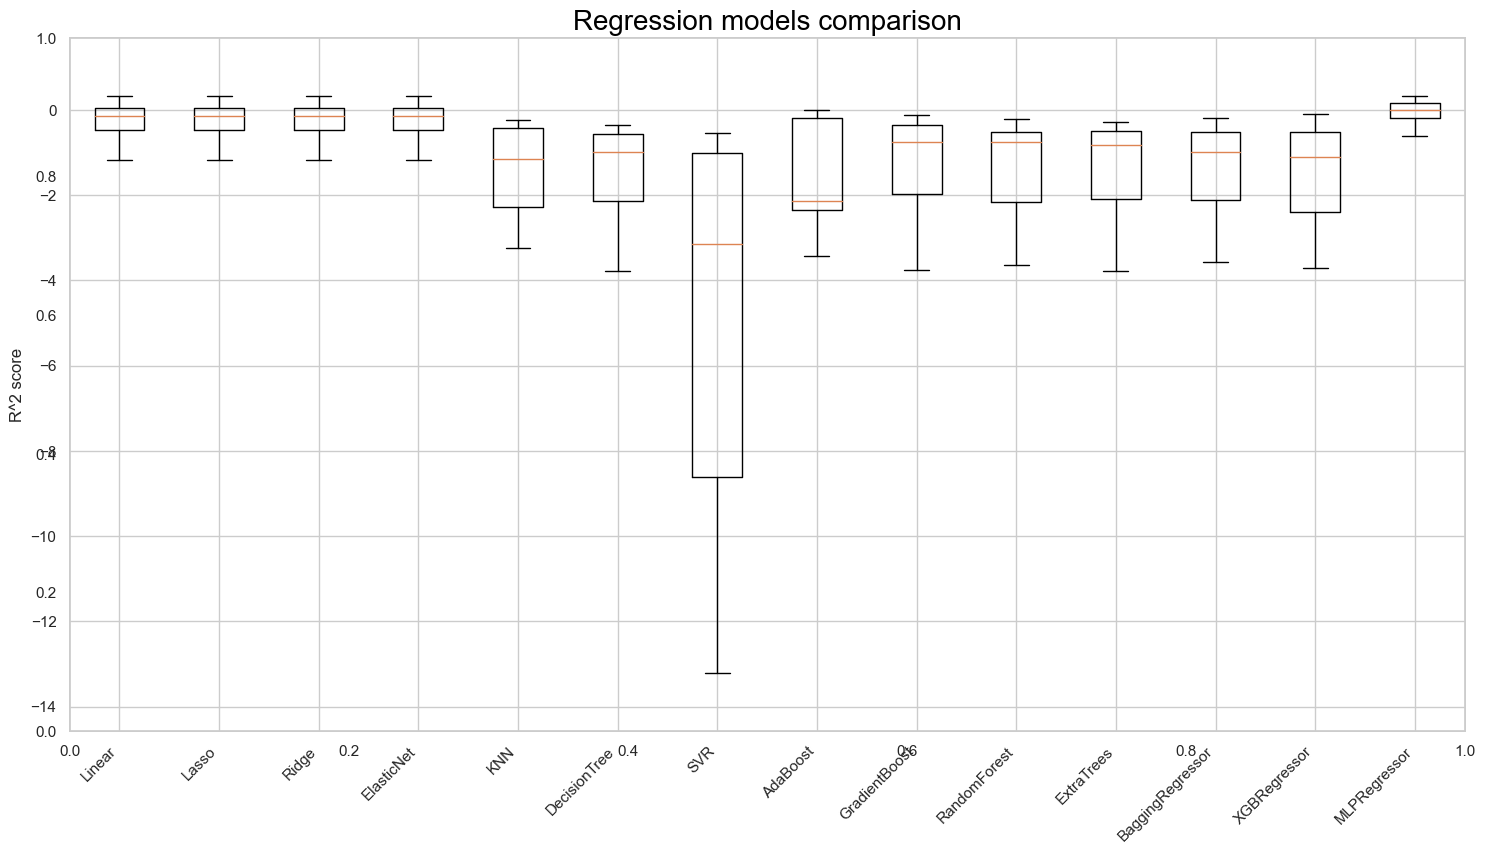

In [15]:
# Compare algorithms  

def box_compare():
  sns.set(rc={'figure.figsize':(18, 9)})
  sns.set_style(style='whitegrid', )
  figure = plt.figure()
  plt.title('Regression models comparison', color = 'black', fontsize = 20)
  axis = figure.add_subplot(111)
  plt.boxplot(model_results)
  axis.set_xticklabels(model_names, rotation = 45, ha="right")
  axis.set_ylabel("R^2 score")
  plt.margins(0.05, 0.1)

box_compare()

The performance scores and box plots show that the linear models and the neural network perform the best. We will select Linear Regression and the MLP Regressor. Both are Gradient-Descent based models, although one is linear and the other non-linear.

## 7. Modelling

We will create, train, test and tune Linear Regression and MLP Regressor models.

### 7.1 Create, train and predict on Linear Regression model

We will look at the Linear Regression model first. It adopts a linear approach to modelling the relationship between a dependent variable and independent variable(s), and is also the simplest form of machine learning.









In [16]:
# Create Linear Regression model
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

LinearRegression()

In [17]:
# Make predictions using the model
predictions = lr.predict(X_test)

### Print performance metrics
The performance metric R<sup>2</sup>, or the coefficient of determination, tells us how much variance in the target variable is explained by our model. Values can range from 0 to 1. In general higher values are better, indicating that a model is highly predictive.

In [18]:
# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))

Coefficients:  [1.01363161]
RMSE: 633.031
R^2 score: 0.84


The R<sup>2</sup> score tells us that 81% of the variation in y can be explained by the dependence on X. 

### Visualise predicted vs actual prices

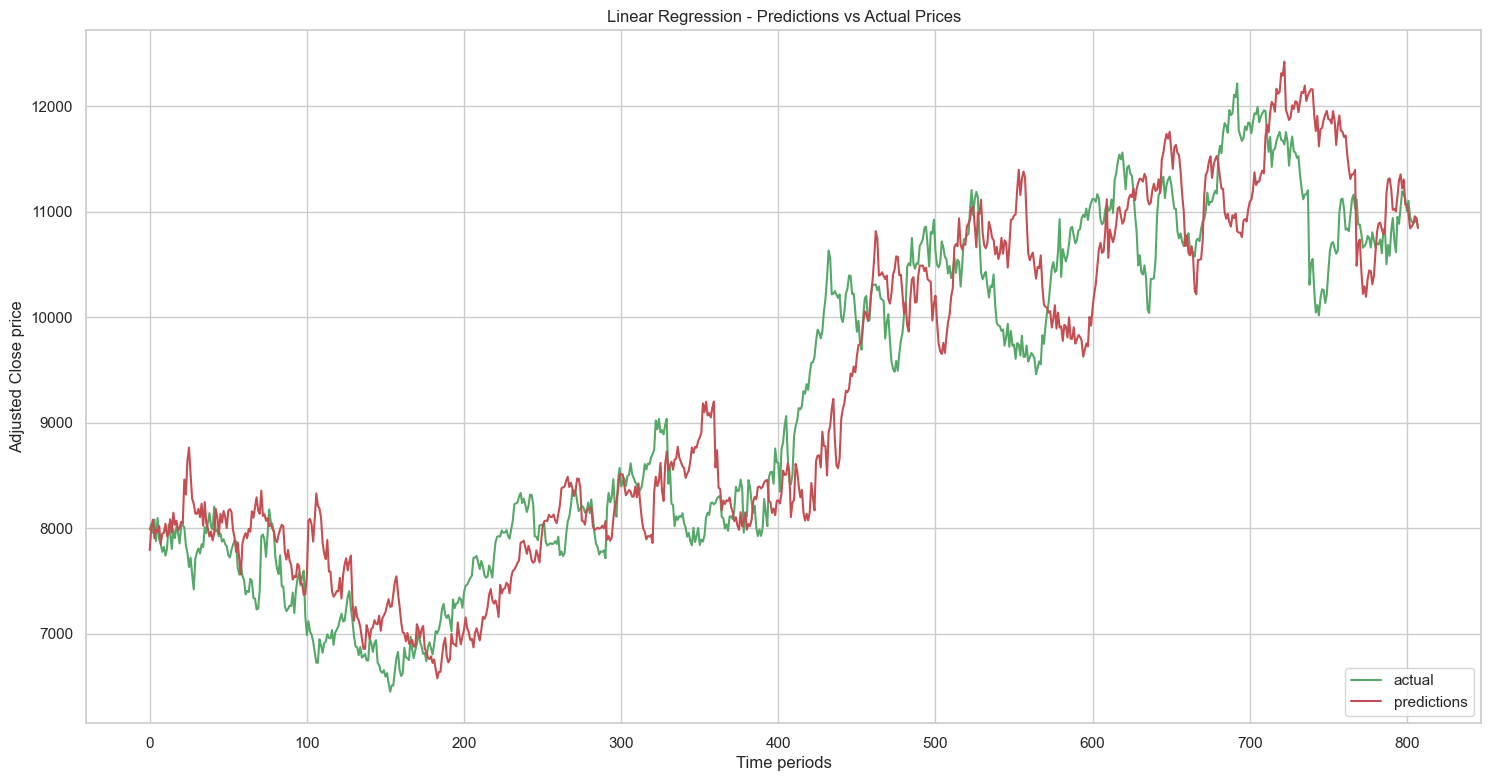

In [19]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, y_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

### Create DataFrame of actual vs predicted prices

In [20]:
pd.DataFrame({"Actual": y_test, "Predict": predictions}).head()

,Actual,Predict
0,7986.93,7791.763286
1,8034.96,8007.078914
2,7956.46,8081.033476
3,8082.06,7903.161401
4,7877.95,7986.481920


### Scatterplot

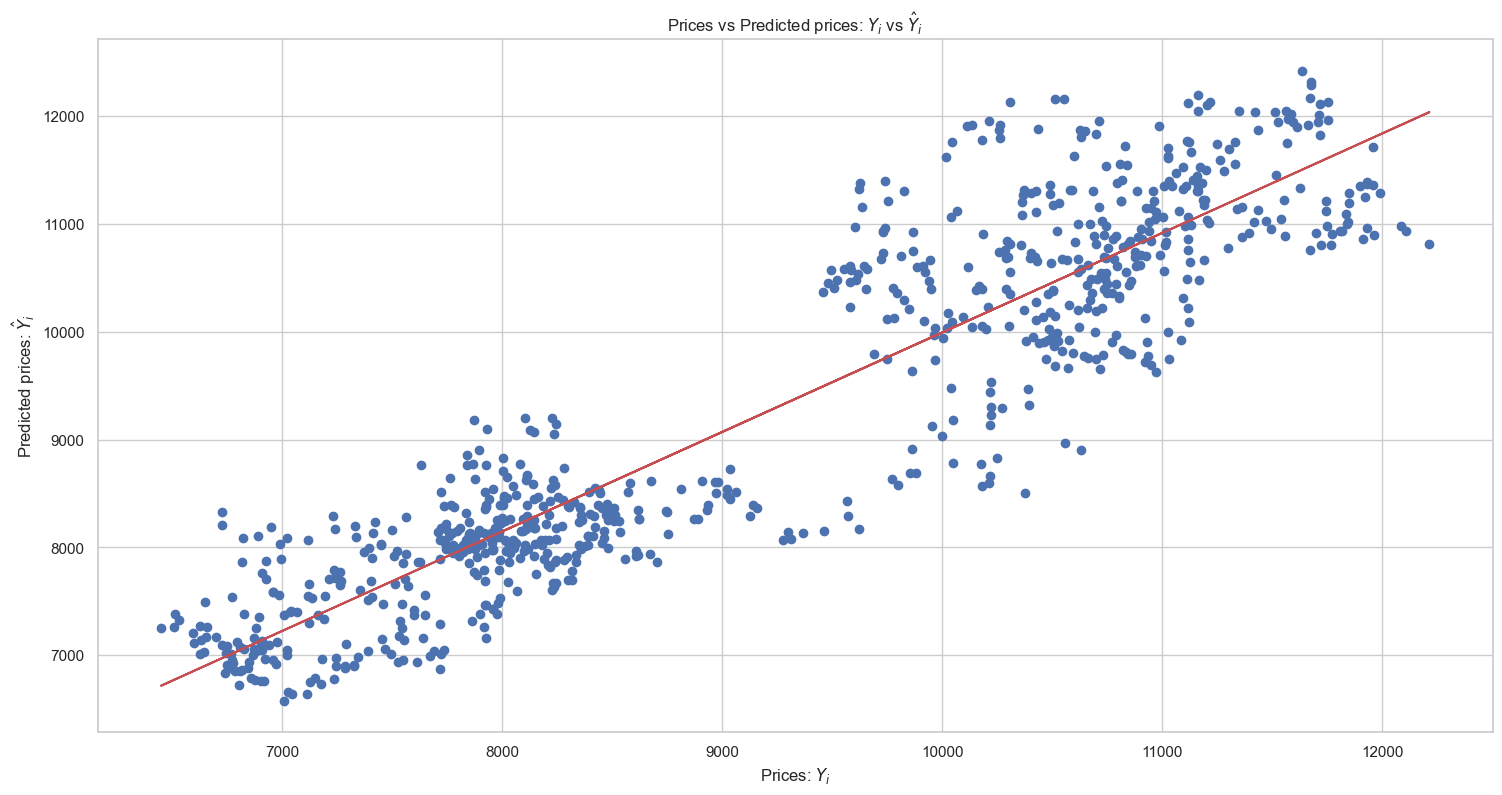

In [21]:
# create basic scatterplot
plt.scatter(y_test,predictions)

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_test, predictions, 1)

# add linear regression line to scatterplot 
plt.plot(y_test, m*y_test+b, c='r')

plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Predict next 30 days 

We will test the model on the X_forecast data and compare predictions with actual prices.

In [22]:
# Predicted prices

lr_prediction = lr.predict(X_forecast)
print(lr_prediction)

[10990.79479712 10919.84058413 10846.85910791 10885.37710925
 10875.24079311 10921.86784736 10790.09573751 11011.06742941
 11033.36732492 10684.67804964 10869.15900342 10765.76857877
 11000.93111327 11128.64869665 10913.75879445 10800.23205366
 11138.78501279 11073.91258949 11236.09364776 11386.11112666
 11355.70217823 11309.07512398 11195.54838319 11292.85701815
 11138.78501279 11096.212485   11079.99437917 11090.13069531
 11130.67595988 11043.50364106]


In [23]:
# Actual prices

X_forecast

array([[10804.],
       [10734.],
       [10662.],
       [10700.],
       [10690.],
       [10736.],
       [10606.],
       [10824.],
       [10846.],
       [10502.],
       [10684.],
       [10582.],
       [10814.],
       [10940.],
       [10728.],
       [10616.],
       [10950.],
       [10886.],
       [11046.],
       [11194.],
       [11164.],
       [11118.],
       [11006.],
       [11102.],
       [10950.],
       [10908.],
       [10892.],
       [10902.],
       [10942.],
       [10856.]])

### Print performance metrics

In [24]:
# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, lr_prediction, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, lr_prediction), 3)))

Coefficients:  [1.01363161]
RMSE: 187.384
R^2 score: -0.14


The R<sup>2</sup> score tells us that 62% of the variation in y can be explained by the dependence on X. 

### Visualise predicted vs actual prices





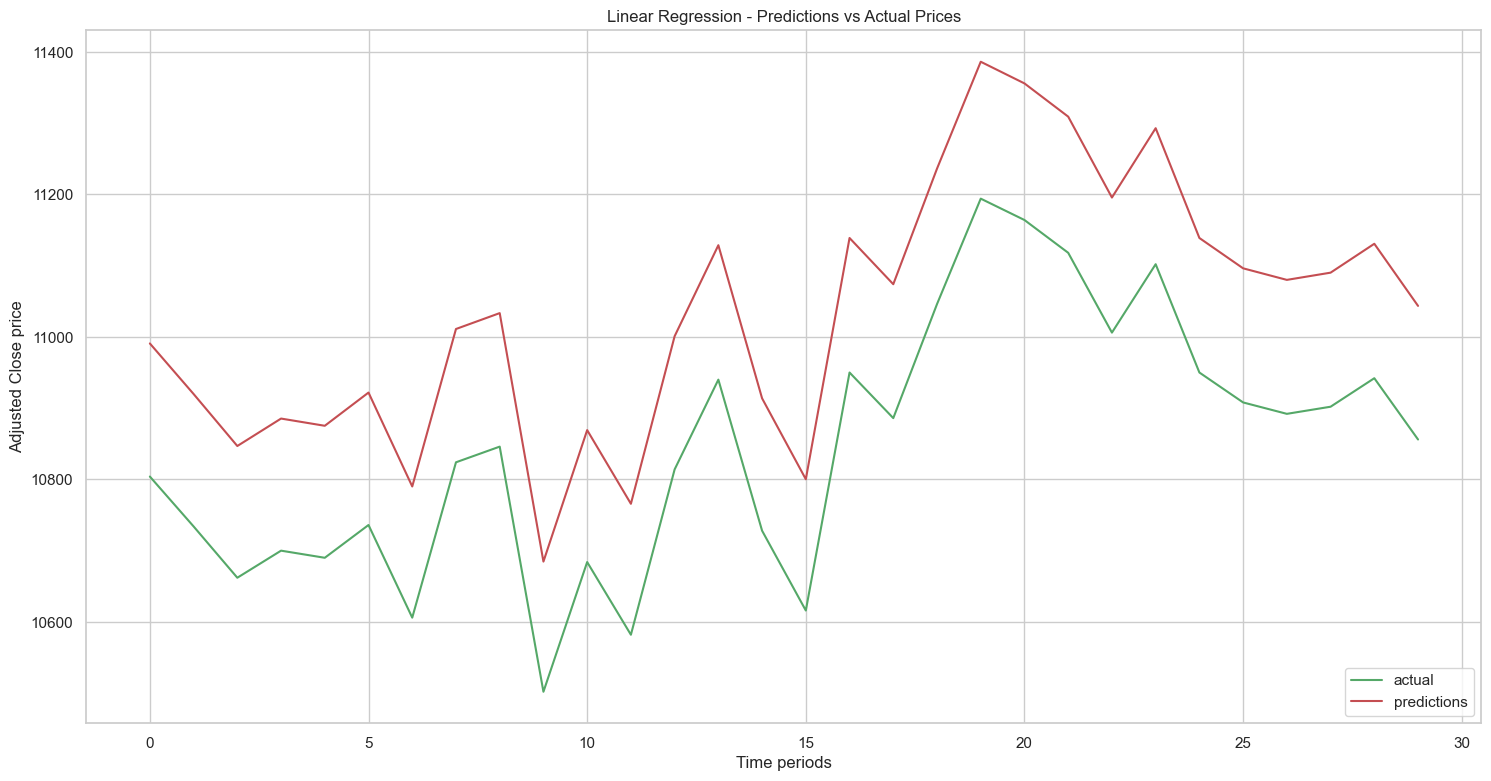

In [25]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, lr_prediction.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, lr_prediction, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

### Create DataFrame of actual vs predicted prices

In [26]:
# Reshape data to be 1D
X_forecast = X_forecast.reshape(-1)
X_forecast 

array([10804., 10734., 10662., 10700., 10690., 10736., 10606., 10824.,
       10846., 10502., 10684., 10582., 10814., 10940., 10728., 10616.,
       10950., 10886., 11046., 11194., 11164., 11118., 11006., 11102.,
       10950., 10908., 10892., 10902., 10942., 10856.])

In [27]:
pd.DataFrame({"Actual": X_forecast, "Predict": lr_prediction}).head()

,Actual,Predict
0,10804.0,10990.794797
1,10734.0,10919.840584
2,10662.0,10846.859108
3,10700.0,10885.377109
4,10690.0,10875.240793


### Grid Search to find optimum parameters

In [37]:
# Create dictionary of parameters
parameters = { 'fit_intercept': [True, False], 'n_jobs': [None, -1]}
type(parameters)

dict

In [31]:
# Grid search to find best parameters
gridsearchcv_lr = GridSearchCV(estimator=lr, param_grid=parameters, cv=tscv, scoring='r2')
grid_result_lr = gridsearchcv_lr.fit(X_train, y_train)
print("Best: {} using {}".format(grid_result_lr.best_score_, grid_result_lr.best_params_))

Best: -0.13526834210435001 using {'fit_intercept': False, 'n_jobs': None}


In [32]:
# All of the best parameters for the optimal model

best_model_lr = grid_result_lr.best_estimator_
print(f"Best model has the following hyperparameters: {best_model_lr}")

Best model has the following hyperparameters: LinearRegression(fit_intercept=False)


### Create, train and test tuned model

In [33]:
# Reshape data to be 2D
X_forecast = X_forecast.reshape(-1,1)
X_forecast

array([[10804.],
       [10734.],
       [10662.],
       [10700.],
       [10690.],
       [10736.],
       [10606.],
       [10824.],
       [10846.],
       [10502.],
       [10684.],
       [10582.],
       [10814.],
       [10940.],
       [10728.],
       [10616.],
       [10950.],
       [10886.],
       [11046.],
       [11194.],
       [11164.],
       [11118.],
       [11006.],
       [11102.],
       [10950.],
       [10908.],
       [10892.],
       [10902.],
       [10942.],
       [10856.]])

In [35]:
# Create Linear Regression model
lr = LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None)

# Train the model using the training sets
lr.fit(X_train, y_train)

# Make predictions using the model
predictions = lr.predict(X_forecast)


# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, predictions), 3)))

Coefficients:  [1.02241828]
RMSE: 243.184
R^2 score: -0.92


The R<sup>2</sup> score has increased from 62% to 84%.

### Visualise predicted vs actual prices of tuned model

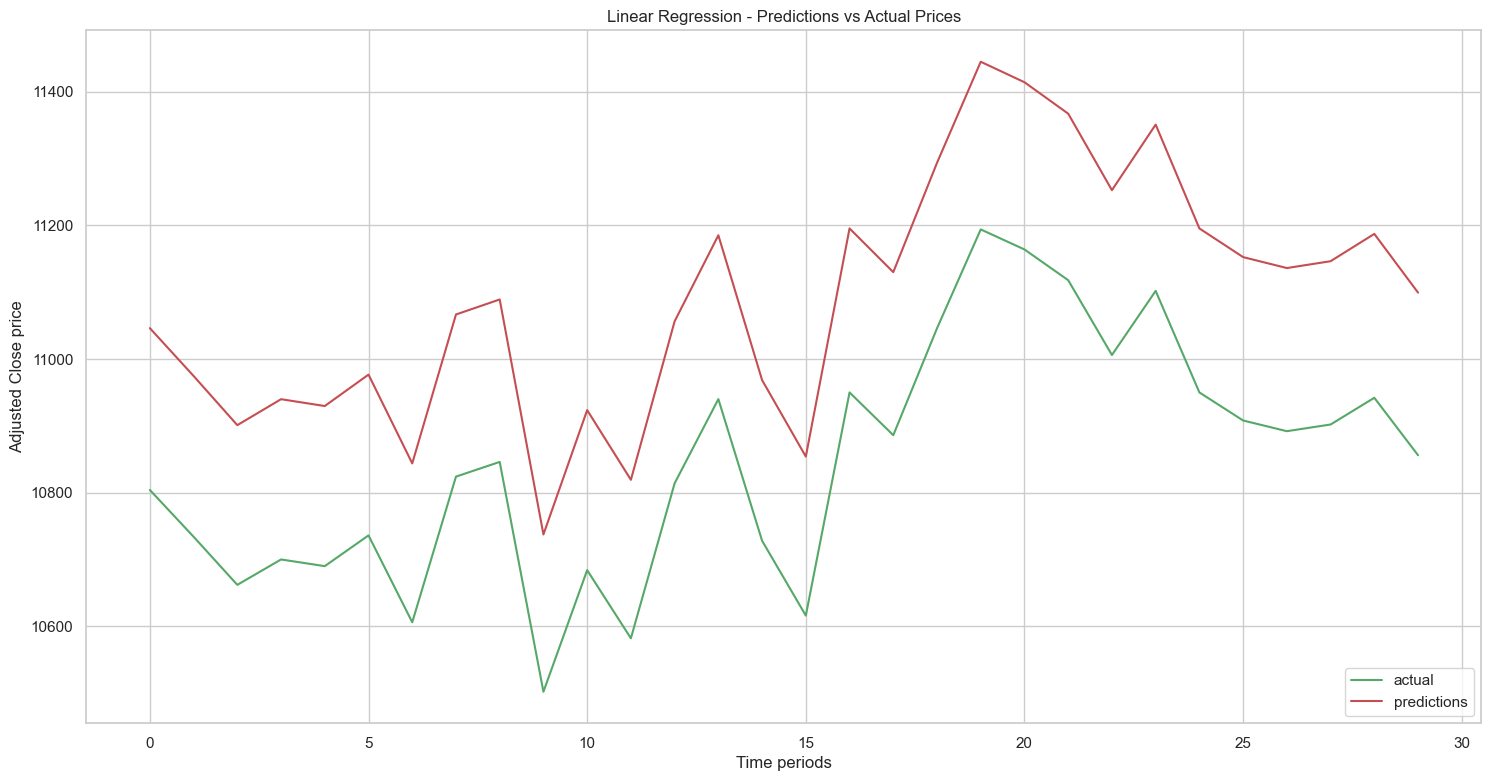

In [36]:
# Plot predictions against actual Adjusted Close prices  

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

We can see that there is now a much better fit.

### 7.2 Create and train MLP Regressor model

The Multi-Layer Perceptron (MLP) Regressor model from scikit-learn is a class of feedforward neural network. We will create and train the model for 500 iterations using the 'lbfgs' solver which is more suited to smaller data sets and can converge faster and perform better than stochastic solvers like 'sgd' and 'adam' which work well on relatively large datasets (with thousands of training samples or more).

In [38]:
# Create an MLP Regressor model  
mlpr = MLPRegressor(max_iter=500, solver = 'lbfgs')

# Train the model using the training sets
mlpr.fit(X_train, y_train)
mlpr

MLPRegressor(max_iter=500, solver='lbfgs')

In [39]:
# Make predictions using the model
predictions = mlpr.predict(X_test)

### Print performance metrics

In [40]:
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))

RMSE: 640.712
R^2 score: 0.836


The R<sup>2</sup> score tells us that 83% of the variation in y can be explained by the dependence on X.

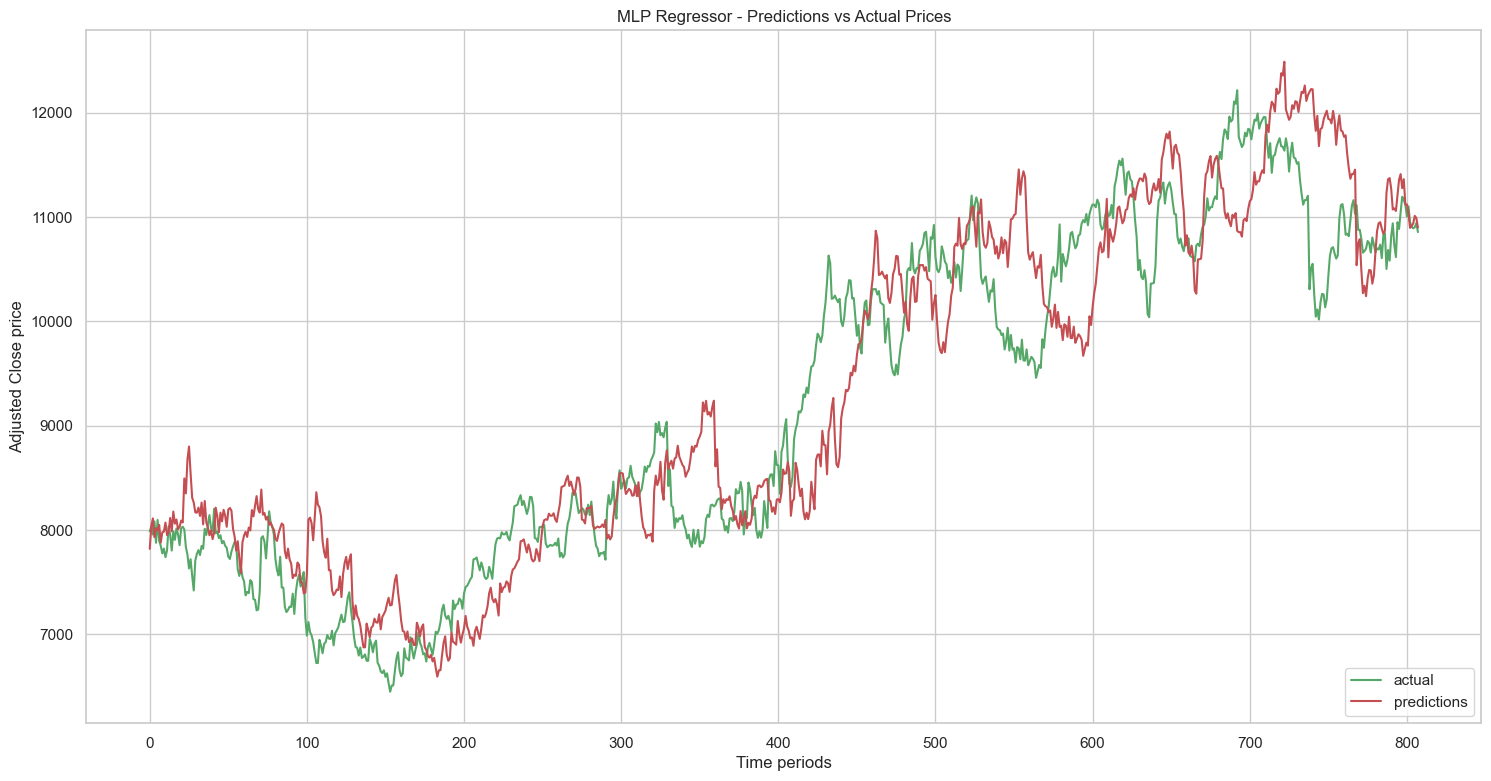

In [41]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, y_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

### Create DataFrame of actual vs predicted prices

In [42]:
pd.DataFrame({"Actual": y_test, "Predict": predictions}).head()

,Actual,Predict
0,7986.93,7819.260833
1,8034.96,8036.430139
2,7956.46,8111.021385
3,8082.06,7931.617987
4,7877.95,8015.655822


### Scatterplot

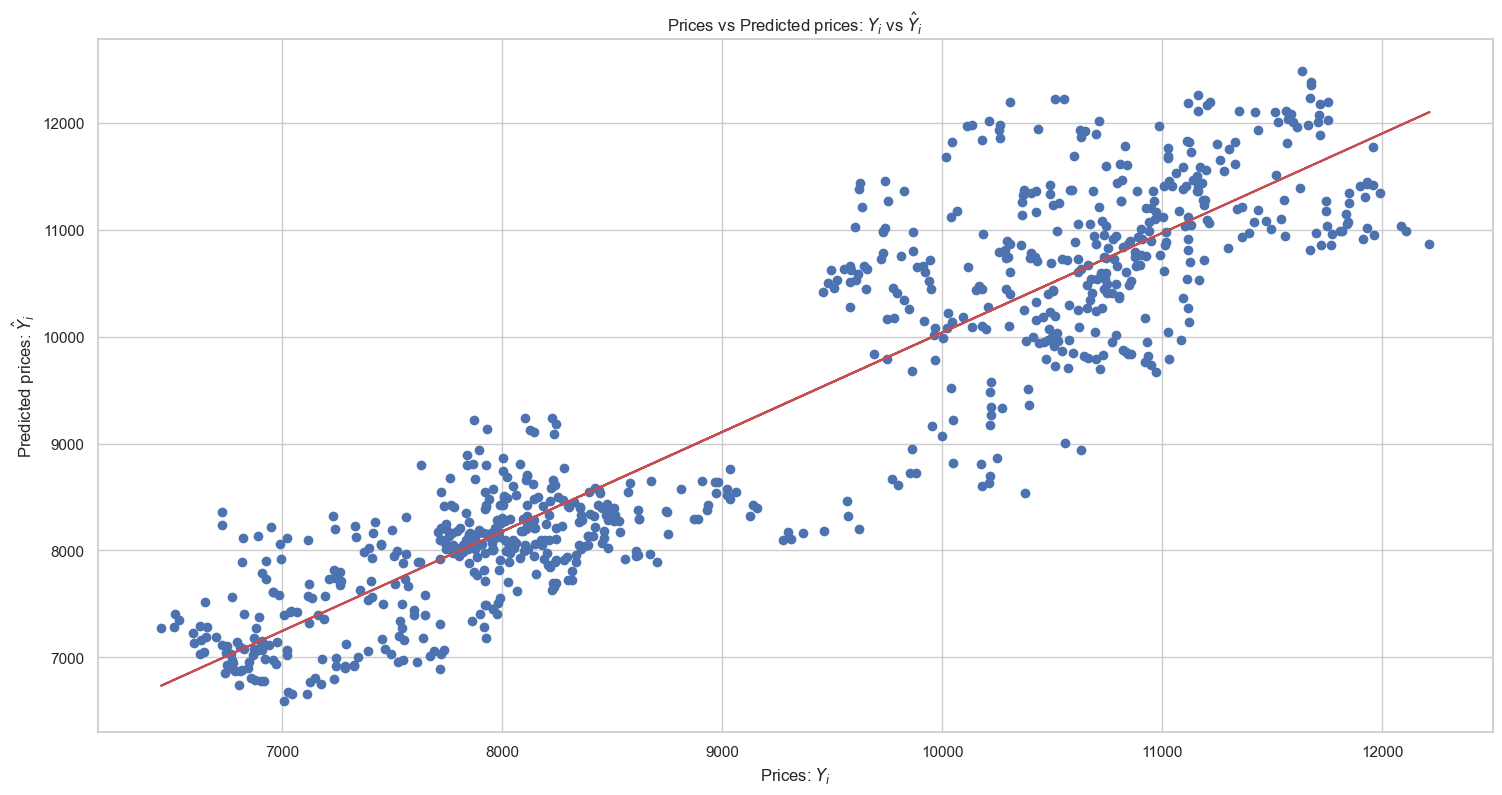

In [43]:
# create basic scatterplot
plt.scatter(y_test,predictions)

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_test, predictions, 1)

# add linear regression line to scatterplot 
plt.plot(y_test, m*y_test+b, c='r')

plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Predict next 30 days 

We will test the model on the X_forecast data and compare predictions with actual prices.

In [44]:
# Predicted prices

mlpr_prediction = mlpr.predict(X_forecast)
print(mlpr_prediction)

[11045.83318955 10974.26812323 10900.65834073 10939.50794816
 10929.28436726 10976.31283941 10843.40628767 11066.28035135
 11088.77222934 10737.08104629 10923.15021871 10818.86969351
 11056.05677045 11184.87388982 10968.13397469 10853.62986858
 11195.09747072 11129.66655295 11293.24384739 11444.55284475
 11413.88210204 11366.85362989 11252.34952378 11350.49590045
 11195.09747072 11152.15843093 11135.80070149 11146.02428239
 11186.918606   11098.99581024]


In [45]:
print(X_forecast)

[[10804.]
 [10734.]
 [10662.]
 [10700.]
 [10690.]
 [10736.]
 [10606.]
 [10824.]
 [10846.]
 [10502.]
 [10684.]
 [10582.]
 [10814.]
 [10940.]
 [10728.]
 [10616.]
 [10950.]
 [10886.]
 [11046.]
 [11194.]
 [11164.]
 [11118.]
 [11006.]
 [11102.]
 [10950.]
 [10908.]
 [10892.]
 [10902.]
 [10942.]
 [10856.]]


### Print performance metrics

In [46]:
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, mlpr_prediction, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, mlpr_prediction), 3)))

RMSE: 242.807
R^2 score: -0.914


The R<sup>2</sup> score tells us that 84% of the variation in y can be explained by the dependence on X. 

### Visualise predicted vs actual prices

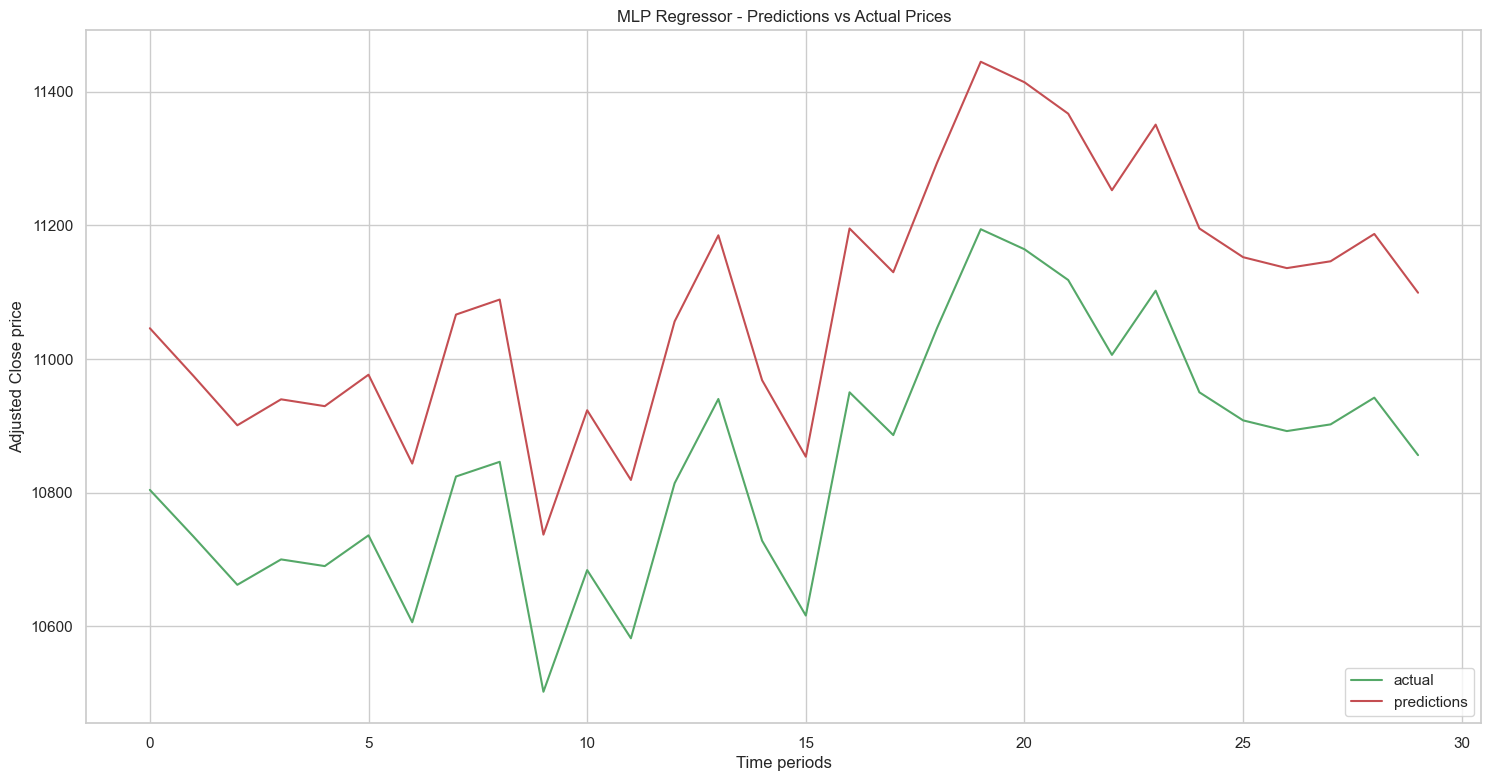

In [47]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, mlpr_prediction.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, mlpr_prediction, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

#### Create DataFrame of actual vs predicted prices

In [48]:
# Reshape data to be 1D
X_forecast = X_forecast.reshape(-1)

In [49]:
pd.DataFrame({"Actual": X_forecast, "Predict": mlpr_prediction}).head()

,Actual,Predict
0,10804.0,11045.833190
1,10734.0,10974.268123
2,10662.0,10900.658341
3,10700.0,10939.507948
4,10690.0,10929.284367


### Feature scaling
Multi-layer Perceptron is sensitive to feature scaling. We will normalise the training data before model fitting by converting values to a common scale. Scikit-Learn’s MinMaxScaler() function scales the data to values between 0 and 1 which helps boost performance. This is useful for optimisation algorithms and used in the core of machine learning algorithms like gradient descent. It is also useful for algorithms that weight inputs, like regression and neural networks.

In [50]:
# Reshape data as this needs to be 2D
y_train = y_train.reshape(-1, 1)

In [51]:
# Normalise data to improve convergence

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_norm = scaler.fit_transform(X_train)
y_train_norm = scaler.transform(y_train)
X_test_norm = scaler.transform(X_test)

### Grid Search to find optimum parameters

In [52]:
# Create model

mlpr = MLPRegressor(max_iter=500)

In [54]:
# Create dictionary of parameters to iterate over

parameters = {"hidden_layer_sizes": [(50,50,50), (50,100,50), (100,)],
              "activation": ["identity", "logistic", "tanh", "relu"], 
              "solver": ["lbfgs", "sgd", "adam"], 
              "alpha": [0.0001, 0.05], 
              "learning_rate": ['constant','adaptive']}

In [55]:
# Grid search to find best parameters

gridsearchcv_mlpr = GridSearchCV(estimator=mlpr, param_grid=parameters, cv=tscv, scoring='r2')
grid_result_mlpr = gridsearchcv_mlpr.fit(X_train_norm, y_train_norm)
print("Best: {} using {}".format(grid_result_mlpr.best_score_, grid_result_mlpr.best_params_))

Best: -0.08569472806172897 using {'activation': 'identity', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'}


In [56]:
# All of the best parameters for the optimal model  

best_model_mlpr = grid_result_mlpr.best_estimator_
print(f"Best model has the following hyperparameters: {best_model_mlpr}")

Best model has the following hyperparameters: MLPRegressor(activation='identity', alpha=0.05, max_iter=500, solver='lbfgs')


### Create, train and test tuned model

In [57]:
# Reshape data to be 2D
X_forecast = X_forecast.reshape(-1,1)
X_forecast

array([[10804.],
       [10734.],
       [10662.],
       [10700.],
       [10690.],
       [10736.],
       [10606.],
       [10824.],
       [10846.],
       [10502.],
       [10684.],
       [10582.],
       [10814.],
       [10940.],
       [10728.],
       [10616.],
       [10950.],
       [10886.],
       [11046.],
       [11194.],
       [11164.],
       [11118.],
       [11006.],
       [11102.],
       [10950.],
       [10908.],
       [10892.],
       [10902.],
       [10942.],
       [10856.]])

In [58]:
# Create MLP Regression model  
mlpr = MLPRegressor(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

# Train the model using the training sets
mlpr.fit(X_train, y_train)

# Make predictions using the model
predictions = mlpr.predict(X_forecast)

# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, predictions), 3)))

RMSE: 243.289
R^2 score: -0.922


The R<sup>2</sup> score has increased from 84% to 97%.

### Visualise predicted vs actual prices of tuned model

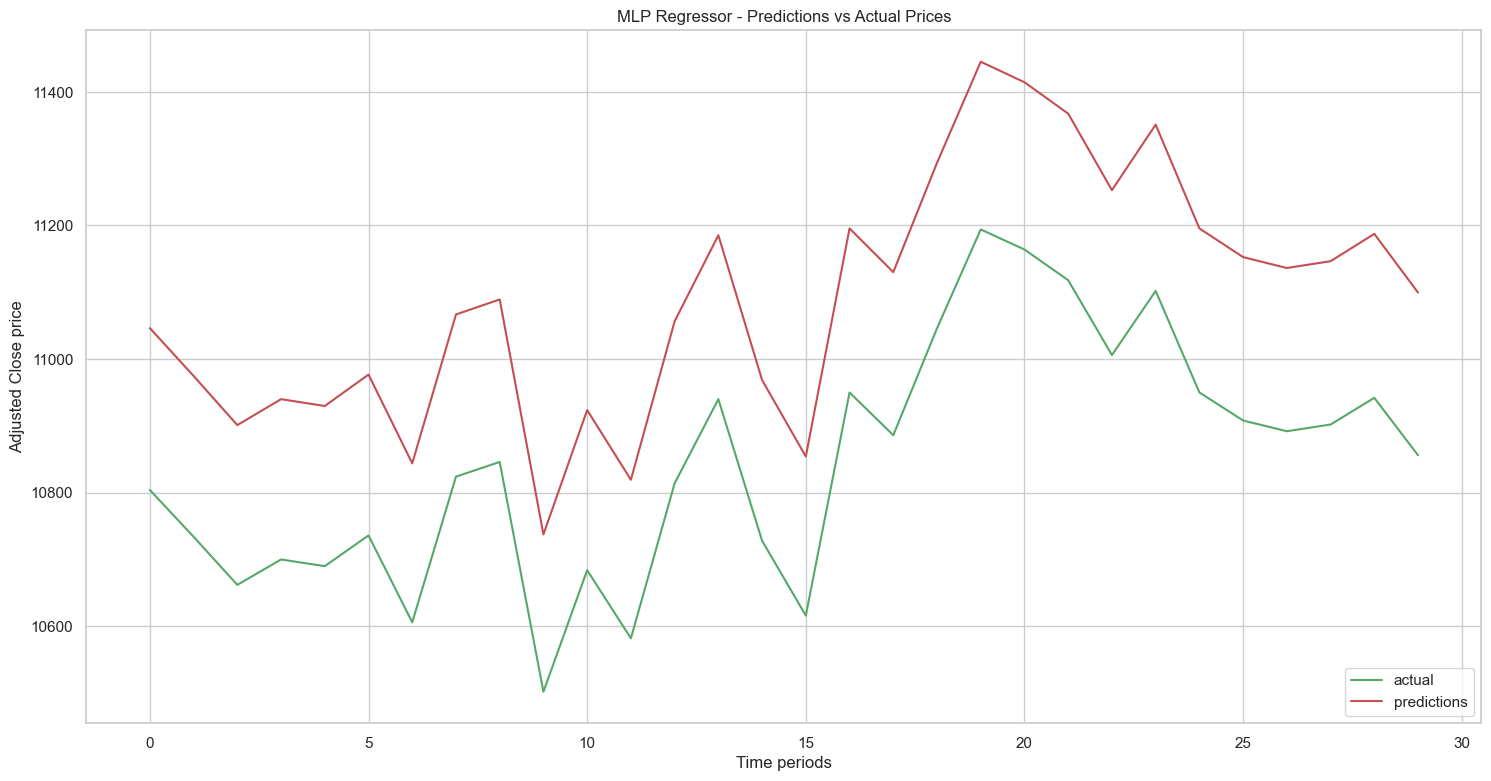

In [59]:
# Plot predictions against actual Adjusted Close prices

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()